In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix
import math
import xgboost as xgb
from scipy.stats import skew
from scipy import stats
import statsmodels
from sklearn.metrics import accuracy_score

import sklearn
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

%matplotlib inline

In [28]:
train = pd.read_csv("../datasets/train.csv")
test = pd.read_csv("../datasets/test.csv")

# full_data = [train, test]

In [29]:
train = train.set_index("PassengerId")
train['train'] = 1
test = test.set_index("PassengerId")
test['train'] = 0

data = train.append(test, ignore_index=True)

In [30]:
train.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [31]:
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket', 'train'],
      dtype='object')

In [32]:
data.describe()

,Age,Fare,Parch,Pclass,SibSp,Survived,train
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838,0.680672
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592,0.466394
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000,1.000000
75%,39.000000,31.275000,0.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000,1.000000


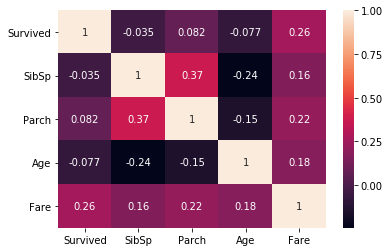

In [33]:
 g = sns.heatmap(data[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True)

In [73]:
def compare_dist(data, var1, var2):
    print(data[[var1, var2]][data[var2].isnull()==False].groupby([var1],
    as_index=False).mean().sort_values(by=var2, ascending=False))
    g = sns.FacetGrid(data, col=var2).map(plt.hist, var1)
    
    max_range = data[var].max() * 1.2
    bins = np.linspace(0, max_range)
    plt.hist(data[data['Survived']==0][var], bins,
            alpha=0.5, normed=True, label='Did Not Survive')
    plt.hist(data[data['Survived']==1][var], bins,
            alpha=0.5, normed=True, label='Survived')
    plt.legend(loc='upper right')
    plt.show()
def compare_mean(data, var1, var2):
    return data[[var1, var2]][data[var2].isnull()==False].groupby([var1],
        as_index=False).mean().sort_values(by=var2, ascending=False)


def compare_hist(data, var):
    max_range = data[var].max() * 1.2
    bins = np.linspace(0, max_range)
    plt.hist(data[data['Survived']==0][var], bins,
            alpha=0.5, normed=True, label='Did Not Survive')
    plt.hist(data[data['Survived']==1][var], bins,
            alpha=0.5, normed=True, label='Survived')
    plt.legend(loc='upper right')
    plt.show()

In [57]:
data['Parch'].max()

9

### Parch vs Survivied

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


NameError: name 'var' is not defined

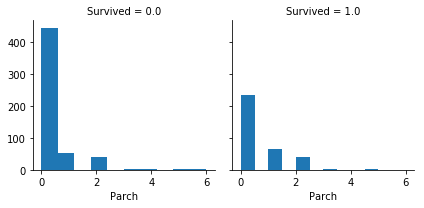

In [74]:
compare_dist(data, 'Parch', 'Survived')

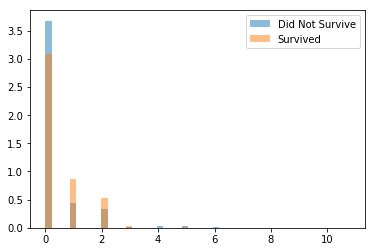

In [72]:
compare_hist(data, 'Parch')

In [11]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [12]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [ ]:
rare_values = []

In [ ]:
train[['Title', 'Survived', 'Age']].groupby(['Title'], as_index=False).mean()
facet = sns.FacetGrid(data = train, hue = "Title", legend_out=True, size = 4.5)
facet = facet.map(sns.kdeplot, "Age")
facet.add_legend();

In [ ]:
data_df.head()

In [ ]:
help(sns.heatmap)

In [ ]:
help(pd.read_csv)